## Dependências

Questões:

● Faça a análise exploratória dos dados, apresente em forma de gráficos e estatísticas dos dados

● Quais os 3 principais fatores que levam a um diagnóstico positivo de diabetes?

● Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?

● Qual a relação entre Polyphagia e o diagnóstico de diabetes?

● Crie um modelo preditivo para a previsão de diabetes que desconsidere as 5 variáveis menos importantes para o diagnóstico.

● Fale sobre as dificuldades que o modelo construído poderia ter para alcançar o sucesso esperado pelo treino em um novo dataset

In [1]:
#Importando bibliotecas
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cloudpickle
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas.api.types import is_numeric_dtype
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
cmap = sns.diverging_palette(0,100,74,39,19,25, center='light', as_cmap=True) #heatmap

## Dados e Constantes

In [2]:
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'diabetes_data.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'test_inter.csv'
DATA_INTER_TRAIN_NAME = 'train_inter.csv'
META_DATA_PATH = os.path.join(DATA_RAW_PATH,'dicionario_tipos.pkl')

In [3]:
#Dados do dicionário
with open(META_DATA_PATH,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)
df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_NAME), dtype=dicionario_tipo)

## Iniciando Análise Exploratória


In [4]:
df_train.head()

,idade,genero,polyuria,polydipsia,perda_de_peso_repentina,fraqueza,polyphagia,candidíase_genital,desfoque_visual,coceira,irritabilidade,cicatrização_retardada,paresia_parcial,rigidez_muscular,alopecia,obesidade,target
0,67,male,no,no,no,no,yes,no,yes,no,no,no,no,yes,no,no,negative
1,55,female,yes,yes,yes,no,yes,no,no,yes,no,yes,yes,no,no,no,positive
2,60,male,no,no,no,yes,no,no,no,no,no,no,yes,yes,no,no,negative
3,48,female,yes,yes,no,yes,no,no,yes,yes,no,yes,yes,no,no,no,positive
4,31,female,yes,yes,yes,yes,yes,no,no,yes,yes,no,yes,yes,no,no,positive


In [5]:
df_train.columns

Index(['idade', 'genero', 'polyuria', 'polydipsia', 'perda_de_peso_repentina', 'fraqueza', 'polyphagia', 'candidíase_genital', 'desfoque_visual', 'coceira', 'irritabilidade', 'cicatrização_retardada', 'paresia_parcial', 'rigidez_muscular', 'alopecia', 'obesidade', 'target'], dtype='object')

In [6]:
df_train.shape

(416, 17)

In [8]:
#Distribuições das váriaveis numéricas. 
todas_as_variaveis = set(df_train.columns.tolist())
variaveis_categoricas = set(df_train.select_dtypes(include=['object']).columns.tolist())
variaveis_numericas = todas_as_variaveis - variaveis_categoricas

## Características Marcantes.


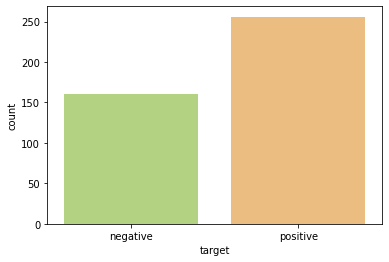

In [9]:
#Plot da distribuição da variável target.
sns.countplot(x=df_train['target'], data=df_train, palette="RdYlGn_r")
plt.show()

Plot do target para verificar se há desbalanceamento, para garantir uma melhor métrica de validição na modelagem

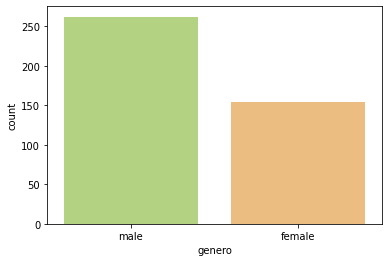

In [10]:
sns.countplot(x="genero", data=df_train,palette="RdYlGn_r")
plt.show()

Na base há mais homens que mulheres.

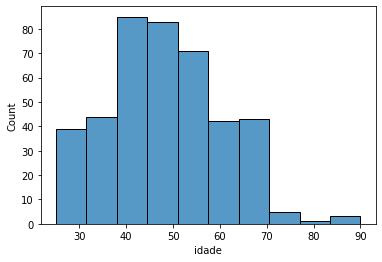

In [11]:
sns.histplot(df_train["idade"], kde=False, bins=10, palette="RdYlGn_r")
plt.show()

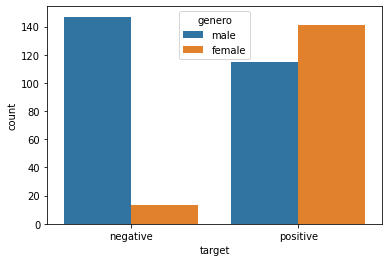

In [12]:
sns.countplot(x='target', hue="genero", data=df_train)
plt.show()

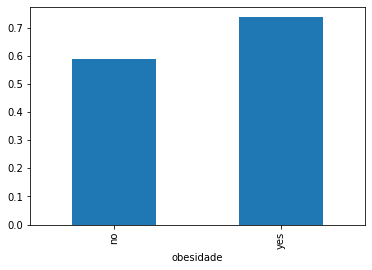

In [13]:
df_train['target'] = df_train['target'].map({'positive': 1, 'negative': 0})
df_train.groupby('obesidade').mean()['target'].plot.bar()
plt.show()

Nesta base, certa de 70% de pessoas que possuem diabetes possuem também obesidade.

## Qual a relação entre Polyphagia e o diagnóstico de diabetes?

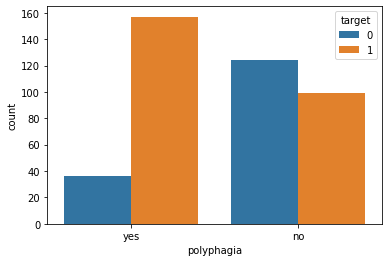

In [14]:
sns.countplot(x='polyphagia', hue="target", data=df_train)
plt.show()

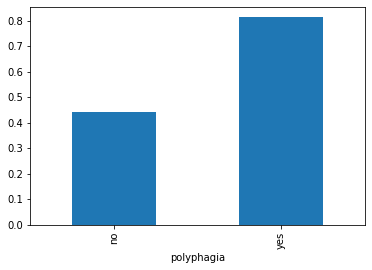

In [15]:
df_train['genero'] = df_train['genero'] .map({'female': 1, 'male': 0})
df_train.groupby('polyphagia').mean()['target'].plot.bar()
plt.show()

Polifagia é um sinal médico que significa fome excessiva e ingestão anormalmente alta de sólidos pela boca, pode-se notar que nesta amostra de dados cerca de 80% de pessoas que possuem`polyphagia` também possuem diabetes.

## Qual a chance de uma pessoa do sexo masculino com menos de 40 anos ter o diagnóstico positivo de diabetes?


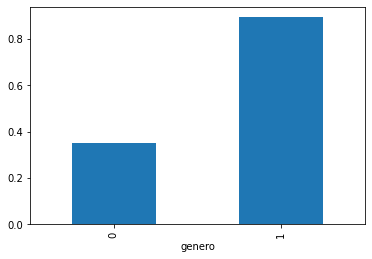

In [20]:
genero_masc = df_train[df_train['genero'] == 0]
genero_masc = df_train[df_train['idade'] < 40]
genero_masc.groupby('genero').mean()['target'].plot.bar()
plt.show()

A chance de uma pessoa do sexo mascoluno com menos de 40 anos ter diabetes nesta amostra dados é aproximadamente de 35%.

In [22]:
list_yes_no = ['polyuria', 'polydipsia', 'perda_de_peso_repentina', 'fraqueza', 'polyphagia', 'candidíase_genital', 'desfoque_visual', 'coceira', 'irritabilidade', 'cicatrização_retardada', 'paresia_parcial', 'rigidez_muscular', 'alopecia', 'obesidade']
for lista in list_yes_no:
    df_train[lista] = df_train[lista].map({"no":0, "yes":1}.get)

/tmp/ipykernel_236483/2519763616.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  corrmat = df_train.astype('int').loc[:,todas_as_variaveis].corr(method='pearson')


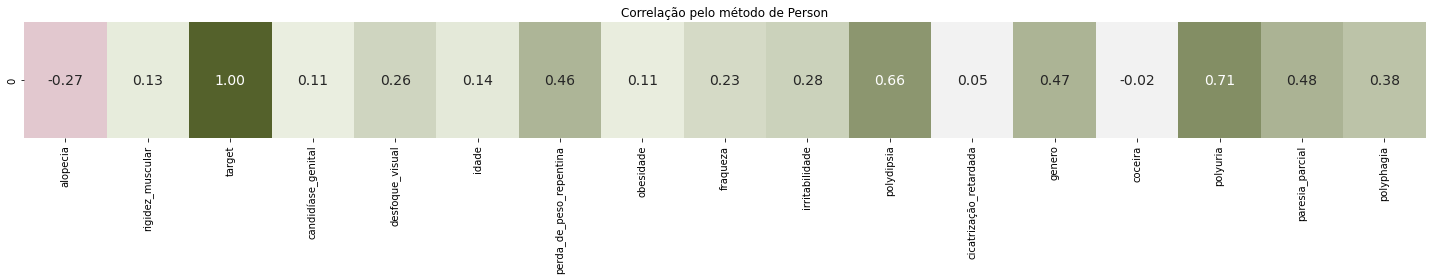

In [23]:
plt.figure(figsize=(20,4))
corrmat = df_train.astype('int').loc[:,todas_as_variaveis].corr(method='pearson')
sns.heatmap([corrmat['target']], xticklabels = corrmat.index,
            annot=True, fmt='.2f', annot_kws={'size': 14},
            cbar=False, center=0,cmap=cmap)
plt.title('Correlação pelo método de Person')
plt.tight_layout()
plt.show()

Afim de verificar a correlação entre o target e as features, para as variáveis catégoricas, O cramer V é usado para examinar a associação entre duas variáveis categóricas quando há mais de uma contingência. Nesses casos, onde as variáveis são categóricas é fundamental a estatística de Cramer, onde o V de Cramer representa a associação ou correlação entre duas variáveis, equivalente a correlação de pearson (para as categóricas). Logo pode-se notar que as variáveis `polyphagia`, `polydipsia`, `genero` e `perda_de_peso_repentina`, possuem uma correlação relativamente alta positiva em relação ao target.
